#                                Browser fingerprint analysis 

## Importing of necessary librairies

In [1]:
%matplotlib notebook
import MySQLdb as mdb
import numpy as np
import csv
import sys
import re
sys.path.append("../src/")
from src.fingerprint import Fingerprint
from src import CSV_DELIMITER

import pandas as pd
import matplotlib.pyplot as plt
from src.analyse import compute_normalized_entropy

DATA_PATH_REL = "../../data/"

#Matplotlib figures inserted into the notebook
%pylab inline

import datetime as datetime
from datetime import date
#import seaborn
import sklearn
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
#import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


## Read the file

In [2]:
# Exclusion of some attributes
ATTRIBUTES_TO_EXCLUDE = [Fingerprint.COUNTER, Fingerprint.CREATION_TIME, Fingerprint.END_TIME, Fingerprint.CONSISTENT]

In [3]:
# read the file
df = pd.read_csv(DATA_PATH_REL + "processed/fingerprint_dataset.csv", delimiter=CSV_DELIMITER, engine="python")
df["creationDate"] = pd.to_datetime(df["creationDate"])

## Visualization of consistent fingerprints

In [4]:
# Analysis of consistent fingerprints
attributes_to_analyze = [attribute for attribute in df.columns.tolist() if attribute not in ATTRIBUTES_TO_EXCLUDE]
df_consistent = df[df[Fingerprint.CONSISTENT] == True ]
print("There are {:d} elements in df_consistent".format(len(df_consistent)))

There are 48714 elements in df_consistent


In [5]:
# Name of attributes
print(df_consistent.columns, "There are {:d} columns in df_consistent".format(len(df_consistent.columns)))

Index(['counter', 'id', 'creationDate', 'endDate', 'addressHttp',
       'userAgentHttp', 'acceptHttp', 'connectionHttp', 'encodingHttp',
       'languageHttp', 'orderHttp', 'pluginsJSHashed', 'platformJS',
       'cookiesJS', 'dntJS', 'timezoneJS', 'resolutionJS', 'localJS',
       'sessionJS', 'canvasJSHashed', 'fontsFlashHashed', 'resolutionFlash',
       'languageFlash', 'platformFlash', 'browserFamily',
       'globalBrowserVersion', 'minorBrowserVersion', 'majorBrowserVersion',
       'os', 'rendererWebGLJS', 'vendorWebGLJS', 'pluginsJS', 'consistent'],
      dtype='object') There are 33 columns in df_consistent


In [149]:
# Visualization of the first 5 lines
df_consistent.head(5)

,counter,id,creationDate,endDate,addressHttp,userAgentHttp,acceptHttp,connectionHttp,encodingHttp,languageHttp,...,platformFlash,browserFamily,globalBrowserVersion,minorBrowserVersion,majorBrowserVersion,os,rendererWebGLJS,vendorWebGLJS,pluginsJS,consistent
15,17,0f4f77e3-80da-4b4a-b9c0-f5e8c4239380,2015-07-27 11:00:00,None,24f5398bba446ce8dadfd3d23ca2f4e58895e76e,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,"text/html,application/xhtml+xml,application/xm...",close,"gzip, deflate, sdch","en-US,en;q=0.8,fr;q=0.6",...,Linux,Chrome,440,0,44,Linux,Mesa DRI Intel(R) Haswell Mobile,Intel Open Source Technology Center,Plugin 0: Chrome PDF Viewer; ; mhjfbmdgcfjbbpa...,True
17,19,74bf8f6f-0114-44b4-9bca-1cfc52ffc2d3,2015-07-27 12:00:00,None,24f5398bba446ce8dadfd3d23ca2f4e58895e76e,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,"text/html,application/xhtml+xml,application/xm...",close,"gzip, deflate, sdch","en-US,en;q=0.8,fr;q=0.6",...,Linux,Chrome,440,0,44,Linux,Mesa DRI Intel(R) Haswell Mobile,Intel Open Source Technology Center,Plugin 0: Chrome PDF Viewer; ; mhjfbmdgcfjbbpa...,True
18,20,df46c5fb-9889-4ff4-9f51-e5af591f3460,2015-07-27 12:00:00,None,24f5398bba446ce8dadfd3d23ca2f4e58895e76e,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,"text/html,application/xhtml+xml,application/xm...",close,"gzip, deflate, sdch","en-US,en;q=0.8,fr;q=0.6",...,Linux,Chrome,440,0,44,Linux,Mesa DRI Intel(R) Haswell Mobile,Intel Open Source Technology Center,Plugin 0: Chrome PDF Viewer; ; mhjfbmdgcfjbbpa...,True
19,21,dc031028-a4ea-4ce8-a362-17b07a4f4d65,2015-07-27 12:00:00,2015-07-28 11:00:00,90f2974eff1d1b3f05d01f413cf0241fae23352e,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_4...,"text/html,application/xhtml+xml,application/xm...",close,"gzip, deflate, sdch","fr-FR,fr;q=0.8,en-US;q=0.6,en;q=0.4",...,Mac OS 10.10.4,Chrome,440,0,44,Mac OS X,Intel HD Graphics 5000 OpenGL Engine,Intel Inc.,Plugin 0: Chrome PDF Viewer; ; mhjfbmdgcfjbbpa...,True
20,22,d51d09c6-2596-4958-bfe7-0352af2aaccf,2015-07-27 12:00:00,2015-07-29 06:00:00,2515ee56512877237d467911f5c55be53eea3550,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,"text/html,application/xhtml+xml,application/xm...",close,"gzip, deflate, sdch","fr-FR,fr;q=0.8,en-US;q=0.6,en;q=0.4",...,Linux,Chrome,430,0,43,Linux,Not supported,Not supported,Plugin 0: Chrome PDF Viewer; ; mhjfbmdgcfjbbpa...,True


In [23]:
print("Statistics on dataset filtered: only consistent browsers") 
number_distinct_list=[]
for attribute in attributes_to_analyze:
    nb_distinct_values_by_attribute = df_consistent[attribute].value_counts()
    nb_distinct_values_global = nb_distinct_values_by_attribute.count()
    nb_unique_values = len(nb_distinct_values_by_attribute[nb_distinct_values_by_attribute.values == 1])


    number_distinct_list.append({
           "Attribute": attribute,
           "Distinct values": nb_distinct_values_global,
           "Unique values": nb_unique_values
      })   
number_distinct_df=pd.DataFrame(number_distinct_list).sort_values(by="Distinct values", ascending=False).reset_index(drop=True)
number_distinct_df

Statistics on dataset filtered: only consistent browsers


,Attribute,Distinct values,Unique values
0,addressHttp,15726,10834
1,fontsFlashHashed,4679,2149
2,id,4643,2123
3,pluginsJSHashed,4186,1940
4,pluginsJS,4185,1940
5,userAgentHttp,2286,980
6,canvasJSHashed,930,289
7,rendererWebGLJS,489,108
8,resolutionJS,446,218
9,languageHttp,422,89


## Descriptive analysis of consistent fingerprints

In [10]:
def display_entropy(df, attributes):
    data_df = []
    for attribute in attributes:
        data_df.append({
           "Attribute": attribute,
           "Relative entropy": compute_normalized_entropy(df, attribute)
       })    
    entropy_df = pd.DataFrame(data_df).sort_values(by="Relative entropy", ascending=False).reset_index(drop=True)
    print(entropy_df)

attributes = [attribute for attribute in attributes_to_analyze if attribute != "id"]
display_entropy(df_consistent, attributes_to_analyze)

               Attribute  Relative entropy
0            addressHttp          0.888301
1                     id          0.781561
2              pluginsJS          0.630395
3          userAgentHttp          0.613847
4        pluginsJSHashed          0.610079
5       fontsFlashHashed          0.542996
6         canvasJSHashed          0.487428
7           languageHttp          0.320505
8           resolutionJS          0.289189
9   globalBrowserVersion          0.269478
10       rendererWebGLJS          0.266548
11   majorBrowserVersion          0.264609
12       resolutionFlash          0.232677
13            timezoneJS          0.227500
14         platformFlash          0.222875
15             orderHttp          0.193803
16                    os          0.171668
17         languageFlash          0.164726
18          encodingHttp          0.122460
19         vendorWebGLJS          0.116709
20            platformJS          0.108445
21         browserFamily          0.087173
22         

In [22]:
# terms : effective, %
# number of unique terms
# most common terms
def terms_analysis(df, attribute):
    tmp_stats = []
    ids = set(df['id'].unique())
    for user_id in ids:
        df_user_id = df[df_consistent['id'] == user_id]
        different_values = df_user_id[attribute].unique()
        for value in different_values:
            tmp_stats.append({
                "id": user_id,
                attribute : value
            })
    df_stats = pd.DataFrame(tmp_stats)
    
    nb = df_stats[attribute].value_counts()
    df_nb = pd.DataFrame(nb)
    
    nb_percent = nb/nb.sum()*100
    df_nb_percent = pd.DataFrame(nb_percent)
    
    tab = df_nb.join(df_nb_percent, lsuffix='_left', rsuffix='_right')
    tab.columns = ['effective', '%']
    
    df_nb[:20].plot(kind='barh', stacked=False, width=0.9, figsize=(10, 6))
    plt.gca().invert_yaxis() 
    plt.grid(axis='x', linestyle = 'dashed')
    plt.title('The 20 first {}'.format(attribute), size=14)
    plt.xlabel('effective', size=14)
    plt.ylabel(attribute, size=14)
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.show()
    
    print(tab)
    print()
    print()
    
#     print("The most used terms are: \n{}".format(nb[:5]))
#     print()
    print("There are {:d} unique terms for the attribute '{}'".format(len(nb[nb.values == 1]), attribute))

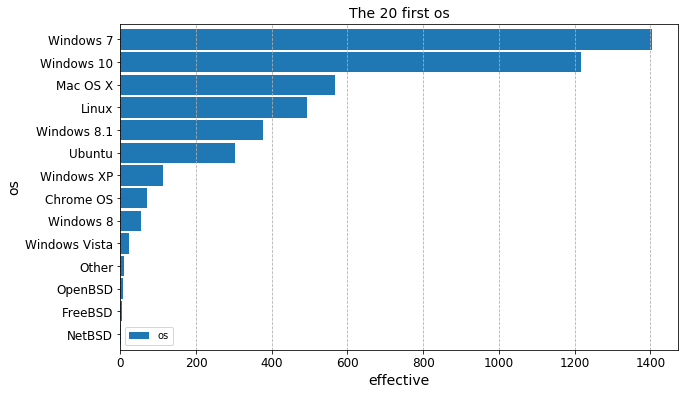

               effective          %
Windows 7           1404  30.239070
Windows 10          1217  26.211501
Mac OS X             566  12.190394
Linux                492  10.596597
Windows 8.1          377   8.119750
Ubuntu               303   6.525953
Windows XP           112   2.412233
Chrome OS             71   1.529184
Windows 8             55   1.184579
Windows Vista         23   0.495369
Other                 11   0.236916
OpenBSD                7   0.150765
FreeBSD                4   0.086151
NetBSD                 1   0.021538


There are 1 unique terms for the attribute 'os'


In [23]:
terms_analysis(df_consistent, 'os')

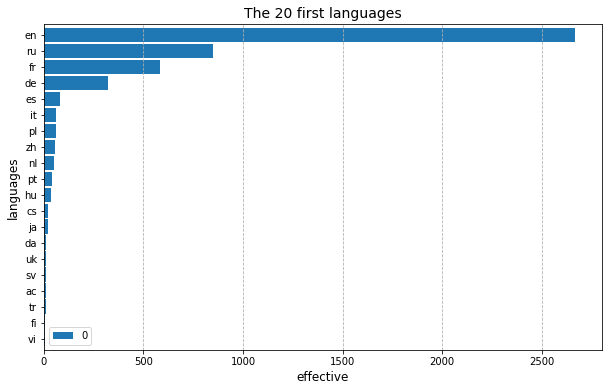


    effective          %
en       2670  53.993933
ru        849  17.168857
fr        582  11.769464
de        320   6.471183
es         79   1.597573
it         61   1.233569
pl         59   1.193124
zh         57   1.152679
nl         52   1.051567
pt         42   0.849343
hu         35   0.707786
cs         21   0.424671
ja         18   0.364004
da         12   0.242669
uk         11   0.222447
sv          8   0.161780
ac          8   0.161780
tr          8   0.161780
fi          6   0.121335
vi          6   0.121335
ko          5   0.101112
sk          5   0.101112
hr          4   0.080890
af          4   0.080890
sl          3   0.060667
lt          3   0.060667
an          2   0.040445
sh          2   0.040445
el          2   0.040445
nb          2   0.040445
bg          2   0.040445
th          1   0.020222
ro          1   0.020222
ch          1   0.020222
et          1   0.020222
az          1   0.020222
ar          1   0.020222
ca          1   0.020222

There are 7 unique term

In [26]:
# terms analysis for the attribute 'languageHttp'
tmp_stats = []
ids = set(df_consistent['id'].unique())
for user_id in ids:
    df_user_id = df_consistent[df_consistent['id'] == user_id]
    different_values = df_user_id['languageHttp'].unique()
    for value in different_values:
        tmp_stats.append({
            "id": user_id,
            'languageHttp' : value
        })
df_stats = pd.DataFrame(tmp_stats)

language_http=df_stats['languageHttp']
language_http_less_nan=language_http.dropna()
language_http_less_nan_list= language_http_less_nan.values.tolist()

languages = []

# takes the first two characters
for i in range(0,len(language_http_less_nan_list)):    
    languages.append(language_http_less_nan_list[i][:2])

langues_df = pd.DataFrame(languages)

# print("The distinct values for the attribute 'languageHttp' are : \n {}".format(langues_df[0].unique()))

    
nb = langues_df[0].value_counts()
df_nb = pd.DataFrame(nb)
    
nb_percent = nb/nb.sum()*100
df_nb_percent = pd.DataFrame(nb_percent)
    
tab = df_nb.join(df_nb_percent, lsuffix='_left', rsuffix='_right')
tab.columns = ['effective', '%']



df_nb[:20].plot(kind='barh', stacked=False, width=0.9, figsize=(10, 6))
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle = 'dashed')
plt.title('The 20 first languages', size = 14)
plt.xlabel('effective', size = 12)
plt.ylabel('languages', size = 12)
plt.show()

print()
print(tab)
print()

print("There are {:d} unique terms for the attribute 'languageHttp'".format(len(nb[nb.values == 1])))
print()
# print("The most used terms are: \n{}".format(nb[:5]))


In [102]:
#modality of plugins
tmp_stats = []
plugins=re.findall("Plugin [0-9]+: ([a-zA-Z -.]+)", str(df_consistent['pluginsJS']))
plugins_df=pd.DataFrame(plugins)
plugins_df[0].unique()

array(['Chrome PDF Viewer', 'Chromium PDF Viewer',
       'Default Browser Helper', 'Shockwave Flash', 'DivX',
       'Gnome Shell Integration', 'Google Update', 'Native Client',
       'Adobe Acrobat'], dtype=object)

In [29]:
def analysis_terms_splited(df, attribute, split_function):
    tmp_dataset = []
    tmp_stats = []
    ids = set(df_consistent['id'].unique())
    for user_id in ids:
        df_user_id = df_consistent[df_consistent['id'] == user_id]
        different_values = df_user_id[attribute].unique()
        for value in different_values:
            tmp_stats.append({
                "id": user_id
            })
            values_split = split_function(value)

            for value_tmp in values_split:
                tmp_dataset.append({
                    "id": user_id,
                    attribute: value_tmp
                })

    df_tmp = pd.DataFrame(tmp_dataset)
    df_stats = pd.DataFrame(tmp_stats)
    
    nb = df_tmp[attribute].value_counts()
    df_nb = pd.DataFrame(nb)
    
    nb_percent = nb/nb.sum()*100
    df_nb_percent = pd.DataFrame(nb_percent)
    
    tab = df_nb.join(df_nb_percent, lsuffix='_left', rsuffix='_right')
    tab.columns = ['effective', '%']
    
    
   
    
    df_nb[:20].plot(kind='barh', stacked=False, width=0.9, figsize=(10, 6))
    plt.gca().invert_yaxis() 
    plt.grid(axis='x', linestyle = 'dashed')
    plt.title('The 20 first {}'.format(attribute), size = 14)
    plt.xlabel('effective', size = 12)
    plt.ylabel(attribute, size = 12)
    plt.show()
    
    print(tab)
    print()
    print("There are {:d} unique terms for the attribute '{}'".format(len(nb[nb.values == 1]), attribute))
#     print()
#     print("The most used terms are: \n{}".format(nb[:5]))
    print()
    print("There are {:d} {}".format(len(nb), attribute))
    
def split_plugins(attribute):
    return re.findall("Plugin [0-9]+: ([a-zA-Z -.]+)", str(attribute))

def split_accept_http(accept):
    return accept.split(",")

# def split_encoding_http(encoding):
#     return encoding.split(", ")

def split_order_http(order):
    return order.split(" ")

def split_encoding_http(encoding):
    try:
        replacement=encoding.replace(","," ")
        junction=''.join(replacement)
        disjunction=junction.split()
        return disjunction 
    except:
        return [""]
 

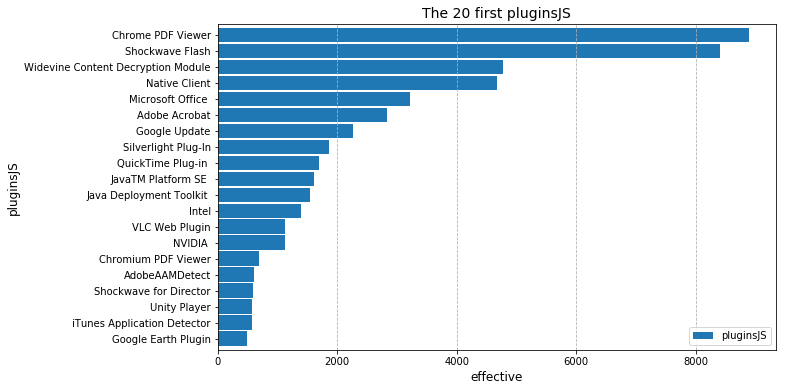

                                      effective          %
Chrome PDF Viewer                          8892  14.638483
Shockwave Flash                            8412  13.848281
Widevine Content Decryption Module         4782   7.872382
Native Client                              4678   7.701172
Microsoft Office                           3224   5.307520
Adobe Acrobat                              2840   4.675359
Google Update                              2265   3.728763
Silverlight Plug-In                        1860   3.062031
QuickTime Plug-in                          1695   2.790399
JavaTM Platform SE                         1604   2.640590
Java Deployment Toolkit                    1538   2.531937
Intel                                      1394   2.294877
VLC Web Plugin                             1122   1.847096
NVIDIA                                     1121   1.845450
Chromium PDF Viewer                         696   1.145792
AdobeAAMDetect                              606   0.9976

In [30]:
analysis_terms_splited(df_consistent, 'pluginsJS', split_plugins)

In [10]:
def analyze_grouped(df, attribute, group_by_attribute):
    tmp_stats = []
    ids = set(df['id'].unique())
    for user_id in ids:
        df_user_id = df[df_consistent['id'] == user_id]
        os_user = df_user_id["os"].values[0]
        browser_user = df_user_id["browserFamily"].values[0]

        different_values = df_user_id[attribute].unique()
        for value in different_values:
            tmp_stats.append({
                "id": user_id,
                "os": os_user,
                "browserFamily": browser_user,
                attribute: value
            })
  
    df_stats = pd.DataFrame(tmp_stats)
    stats_grouped = df_stats[group_by_attribute].value_counts()
    grouped = df_stats.groupby([attribute])
    for name, group in grouped:
        norm = 0 
        count_per_group = group[group_by_attribute].value_counts()
        for key, number in stats_grouped.iteritems():
            try:
                norm += abs(number - count_per_group[key])
            except KeyError:
                norm += abs(number)

        if norm >= 0:
            print(name)
            print(count_per_group)

        print(norm)

In [38]:
analyze_grouped(df_consistent,'localJS', 'sessionJS')

KeyError: 'sessionJS'

In [11]:
def analyze_grouped_splited(df, attribute, group_by_attribute, split_function):
    tmp_dataset = []
    tmp_stats = []
    ids = set(df['id'].unique())
    for user_id in ids:
        df_user_id = df[df['id'] == user_id]
        os_user = df_user_id["os"].values[0]
        browser_user = df_user_id["browserFamily"].values[0]

        different_values = df_user_id[attribute].unique()
        for value in different_values:
            tmp_stats.append({
                "id": user_id,
                "os": os_user,
                "browserFamily": browser_user
            })
            values_split = split_function(value)

            for value_tmp in values_split:
                tmp_dataset.append({
                    "id": user_id,
                    "os": os_user,
                    "browserFamily": browser_user,
                    attribute: value_tmp

                })

    df_tmp = pd.DataFrame(tmp_dataset)
    df_stats = pd.DataFrame(tmp_stats)
    
    
    stats_grouped = df_stats.groupby(group_by_attribute).size()
    #print(stats_grouped)
    #stats_grouped = df_stats[group_by_attribute].value_counts()
    grouped = df_tmp.groupby([attribute])
    for name, group in grouped:
        norm = 0 
        count_per_group = group.groupby(group_by_attribute).size()
        #count_per_group = group[group_by_attribute].value_counts()
        for key, number in stats_grouped.iteritems():
            try:
                norm += (number - count_per_group[key])**2
            except KeyError:
                norm += number**2

        if norm >= 0:
            print(name)
            print(count_per_group)

        print(norm)

def split_headers(headers):
    return headers.split(" ")

def split_languages_http(languages):
    try:
        return languages.split(";")
    except AttributeError:
        return str(languages)
    
def split_accept_http(accept):
    return accept.split(",")

def split_plugins(attribute):
    return re.findall("Plugin [0-9]+: ([a-zA-Z -.]+)", str(attribute))

def split_order_http(order):
    return order.split(" ")

def split_encoding_http(encoding):
    try:
        replacement=encoding.replace(","," ")
        junction=''.join(replacement)
        disjunction=junction.split()
        return disjunction 
    except:
        return [""]

In [23]:
analyze_grouped_splited(df_consistent, 'encodingHttp', 'browserFamily', split_encoding_http)


browserFamily
Firefox    3
dtype: int64
11703118
br
browserFamily
Chrome            1597
Chromium            43
Dragon               3
Epiphany             1
Firefox           1912
IE Mobile            1
Iceweasel            3
Iron                28
Konqueror            1
Opera                8
Other                5
QupZilla             1
Rekonq               1
SeaMonkey            1
Vivaldi             38
Yandex Browser       4
dtype: int64
876300
bzip2
browserFamily
Chrome    1
dtype: int64
11713896
compress
browserFamily
Chrome    1
dtype: int64
11713896
deflate
browserFamily
Chrome                         2274
Chromium                         72
Dragon                            9
Epiphany                          2
Firefox                        2553
IE Mobile                         1
Iceweasel                        32
Iron                             37
Konqueror                         1
Maxthon                           1
Opera                            15
Other           

In [165]:
analyze_grouped_splited(df_consistent, 'vendorWebGLJS', ['os', 'browserFamily'], split_plugins)

os             browserFamily              
Chrome OS      Chrome                          72
FreeBSD        Chrome                           1
               Firefox                          3
Linux          Chrome                         304
               Firefox                        177
               Iceweasel                       32
               Iron                             6
               Konqueror                        1
               Opera                            1
               QupZilla                         1
               Rekonq                           1
               Vivaldi                         14
Mac OS X       Chrome                         390
               Firefox                        191
               Iron                             1
               Opera                            2
               SeaMonkey                        1
               Vivaldi                          6
NetBSD         Firefox                          1
OpenBSD

KeyError: 'vendorWebGLJS'

## Inconsistent fingerprint detection

In [139]:
dict_null=[]
for attribute in attributes_to_analyze:
    nb_values_null = len(df_consistent[df_consistent[attribute].isnull()])
    dict_null.append({
        "attribute":attribute,
        "number of values null":nb_values_null
    })
df_dict_null = pd.DataFrame(dict_null)
df_dict_null

,attribute,number of values null
0,id,0
1,addressHttp,0
2,userAgentHttp,7
3,acceptHttp,0
4,connectionHttp,0
5,encodingHttp,2
6,languageHttp,15
7,orderHttp,0
8,pluginsJSHashed,0
9,platformJS,1


In [142]:
# Détection of inconsistent values
df_consistent[df_consistent['platformJS'].isnull()]

,counter,id,creationDate,endDate,addressHttp,userAgentHttp,acceptHttp,connectionHttp,encodingHttp,languageHttp,...,platformFlash,browserFamily,globalBrowserVersion,minorBrowserVersion,majorBrowserVersion,os,rendererWebGLJS,vendorWebGLJS,pluginsJS,consistent
38502,49117,bb2d1703-0c56-49cd-bf02-4af5d1bceb30,2016-06-30 12:00:00,None,5aff60bc3b6c8c04f3c5934e10a9cfff857751a2,Mozilla/5.0 (Windows NT 6.0) AppleWebKit/537.3...,"text/html,application/xhtml+xml,application/xm...",close,"gzip, deflate","en-GB,en;q=0.5",...,Windows 7,Chrome,450,0,45,Windows Vista,Not supported,Not supported,Plugin 0: Adobe Acrobat; Adobe PDF Plug-In For...,True


In [119]:
# Id of the fingerprint to take off it from consistent fingerprints
df_consistent[df_consistent['id'] == "d2356d2d-9796-4522-949e-616aa1521059"]

,counter,id,creationDate,endDate,addressHttp,userAgentHttp,acceptHttp,connectionHttp,encodingHttp,languageHttp,...,platformFlash,browserFamily,globalBrowserVersion,minorBrowserVersion,majorBrowserVersion,os,rendererWebGLJS,vendorWebGLJS,pluginsJS,consistent
71595,93843,d2356d2d-9796-4522-949e-616aa1521059,2016-12-04 01:00:00,None,8f60d3ad84d108cabb80a4e40a488878396c0448,NaN,"text/html,application/xhtml+xml,application/xm...",close,"gzip, deflate, br","en-US,en;q=0.5",...,Flash not detected,Other,zzzzzz,None,None,Other,Not supported,Not supported,NaN,True


In [109]:
df_consistent['browserFamily'].value_counts()

Chrome                         28157
Firefox                        19183
Chromium                         425
Iron                             353
Vivaldi                          220
Iceweasel                        141
Opera                             71
Dragon                            37
Yandex Browser                    21
Other                             11
IE Mobile                          3
Epiphany                           2
Pale Moon (Firefox Variant)        2
Maxthon                            1
Rekonq                             1
QupZilla                           1
SeaMonkey                          1
Konqueror                          1
Name: browserFamily, dtype: int64

In [165]:
df_consistent[df_consistent['encodingHttp'] == "gzip, deflate, , br"]["id"]

82110    b6c38cfd-7fc0-4591-b908-bcd7769ab2b5
Name: id, dtype: object

## Temporal analysis of consistent fingerprints

In [36]:
#id with more 2 fingerprints
number_fingerprints_by_id=df_consistent['id'].value_counts()
df_number_fingerprints_by_id=pd.DataFrame(number_fingerprints_by_id)
user_more_2_fingerprints=[]
for user_id, number in df_number_fingerprints_by_id.iteritems():
    for i in range(0, len(number)):
        if number[i] != 1:
            user_more_2_fingerprints.append({
                "valeur":number[i],
                "index":number.index[i]
            })
            
df_user_more_2_fingerprints=pd.DataFrame(user_more_2_fingerprints)

### Frequency of attributes changes

In [164]:
#frequency of changes of each attribute in time (days)
List_frequency_attributes=[]
attribute_to_times = dict()

#take only users with more 2 fingerprints to see the evolution in fingerprints for each user
for user_id in df_user_more_2_fingerprints['index']:
    df_filtered_id = df_consistent[df_consistent['id']==user_id].sort_values('creationDate')

    #for each attribute, we store the date of creation and the first value of the first fingerprint of user
    for attribute in attributes_to_analyze:
        first_value_date = df_filtered_id.iloc[0]['creationDate']
        first_value = df_filtered_id.iloc[0][attribute]
        
        #if there are no changes
        if attribute not in attribute_to_times:
            attribute_to_times[attribute] = []
        
        last_change = False
        
        #count the number of days between each changes in the attribute then store it in a dict
        for index, row in df_filtered_id.iterrows():
            if row[attribute]!= first_value:
#                 print(row[attribute])
#                 print(first_value)
#                 print()
                date_next=row['creationDate']
                attribute_to_times[attribute].append((date_next-first_value_date).days)
                first_value_date=row['creationDate']
                first_value=row[attribute]
            
                #if there is a change in the n-1 value then we say that there is a last change
                if index == len(df_filtered_id) -1:
                    last_change = True
            

        #Otherwise, we add to the list the NaN value    
        if not last_change:
            attribute_to_times[attribute].append(np.nan)
          
            
            
dict_stat=[]
for attribute in attribute_to_times:
    #try:
        # sort in descending order
    arr = np.sort(attribute_to_times[attribute])[::-1]

    #creation of quantiles
    Q95 = arr[int(0.95*len(arr))]
    Q90 = arr[int(0.90*len(arr))]
    median = arr[int(0.50*len(arr))]
    dict_stat.append({
        "attribute":attribute,
        "Q90":Q90,
        "median":median,
        "Q95":Q95
    })
    #except IndexError:
#        pass

#create a dataframe for the visualization
df_stat = pd.DataFrame(dict_stat)

#put in index the name of attributes
df_stat = df_stat.set_index("attribute")

#replace NaN by 'Never'
for column in df_stat:
    df_stat[column].replace(to_replace=[NaN], value='Never', inplace=True) 

df_stat_order = df_stat[['median','Q90','Q95']]
df_stat_order

,median,Q90,Q95
attribute,,,
id,Never,Never,Never
addressHttp,2,0,0
userAgentHttp,23,0,0
acceptHttp,Never,Never,Never
connectionHttp,Never,Never,Never
encodingHttp,Never,11,0
languageHttp,Never,5,0
orderHttp,Never,0,0
pluginsJSHashed,28,0,0


### Does everyone change so often ?

In [31]:
list_all=[]
list_freq=[]
for user_id in df_user_more_2_fingerprints['index']:
    df_filtered_id = df_consistent[df_consistent['id']==user_id].sort_values('creationDate')
    
    df_filtered_date = df_filtered_id.drop('counter', 1).drop('endDate', 1).drop('consistent', 1).drop('creationDate', 1)

    liste_time = []

    first_line = df_filtered_date.iloc[0]
    list_first_line = list(first_line)

    first_value_date = df_filtered_id.iloc[0]['creationDate']
    last_value_date = df_filtered_id.iloc[-1]['creationDate']

    # for each line of group of fingerprints of the user
    for line in range(1, len(df_filtered_date)):
        line_entire=df_filtered_date.iloc[line]
        list_line_entire = list(line_entire)
        
        # if line next is defferent to previous line then storage of number of days between the two lines
        if list_line_entire != list_first_line:
            date_line = df_filtered_id.iloc[line]['creationDate']
            liste_time.append((date_line-first_value_date).days)
            first_value_date = df_filtered_id.iloc[line]['creationDate']
            first_line = line_entire
        # else the first line becomes the next
        else:
            first_line = line_entire
    
    # storage of all values in a single list for cumulative distribution for all fingerprints
#     list_all.append(np.nanmean(liste_time))
    # average of each list of values for each user
#     mean_liste=np.nanmean(liste_time)
    list_freq.append({
        'user':user_id,
        'mean':np.nanmean(liste_time)
    })

# for the visualization : creation a dataframe
df_list_freq=pd.DataFrame(list_freq)
df_list_freq

/home/spirals/PycharmProjects/stage/myvenv/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: Mean of empty slice


,mean,user
0,0.101572,c3af36ba-81f4-4652-9523-44f2217dc0f0
1,0.290965,2bef0281-b2d9-41ac-967c-45835e5ba8c0
2,0.294393,efca79c2-0b12-4ce7-a28f-68ad9193990d
3,0.000000,77aae6f6-0bbd-4138-baa4-142c1e4dddcd
4,0.801402,f61809d2-a428-4a2c-81e4-461ea9908687
5,0.904878,d4be492d-c9ee-46a0-b1ab-076386b61b85
6,0.780488,68942969-0475-4a26-931b-d1d8043a659c
7,0.801090,31fa27b8-6c4d-47b2-8566-b4af4d9ca9e8
8,1.395498,c17f5405-360e-43d7-9b50-bccf6faf2207
9,0.621723,ac7c0dae-6fe3-48e3-97b7-ab62571a0eb1


In [8]:
# graph
# max_abs is the value for the maximum of the abscissa axe and probability = [0.0:1.0]

def CDF_evolution(max_abs, probability):  
    
    # sort 
    x_fig_average = np.sort(df_list_freq['mean'])
    x_fig_all = np.sort(list_all)

    # length
    N_fig_average = len(x_fig_average)
    N_fig_all = len(x_fig_all)

    #creation of the y-axis for a cumulative distribution function
    y_fig_average = np.array(range(N_fig_average))/float(N_fig_average)
    y_fig_all = np.array(range(N_fig_all))/float(N_fig_all)

    # dimension of the figure
    fig = plt.figure(figsize=(15,9))

    ax = fig.add_subplot(1, 1, 1)
    ax.plot(x_fig_all, y_fig_all, label = 'Over all fingerprints')
    ax.plot(x_fig_average, y_fig_average, label = 'Average per user')
    
    # horizontal line for the percentile
    ax.plot([0.0, 50],[probability,probability], 'g--', lw=2)

    # legend in better place
    ax.legend(loc='best', prop={'size': 12})

    # interval of the abscissa axis and y-axis 
    ax.set_xlim(-0.05, max_abs)
    ax.set_ylim(0,1)
    
    ax.set_title("Cumulative distribution function of the elapsed time before a fingerprint evolution \nover all fingerprints and averaged per user\n")
    ax.set_xlabel("Days before a change occurs in a fingerprint", size = 12)
    ax.set_ylabel("P(X)", size = 12)
    
    # graduation of abscissa axis with a one step
    ax.xaxis.set_major_locator(MultipleLocator(1))


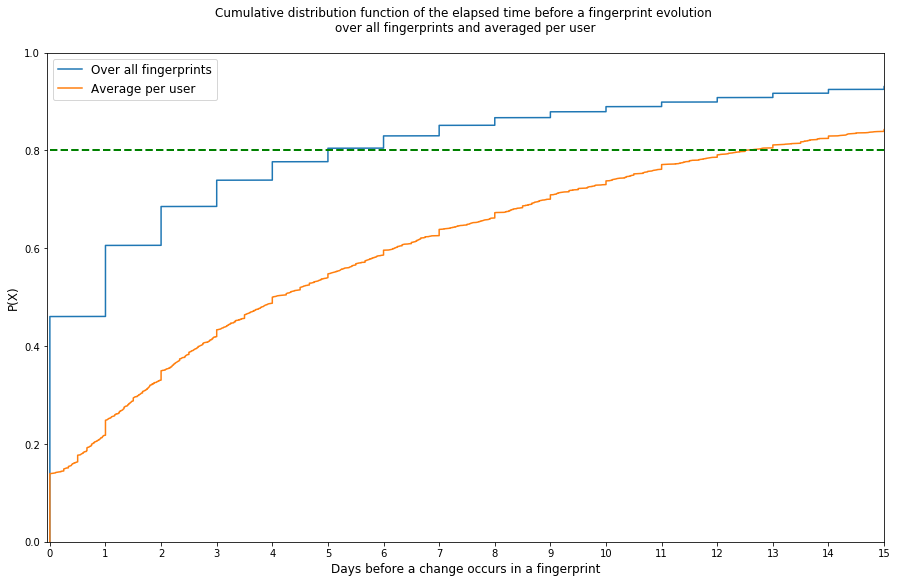

In [181]:
CDF_evolution(15,0.8)

### Attributes that change at the same time

In [24]:
df_consistent['creationDate'].iloc[-1] - df_consistent['creationDate'].iloc[0]

Timedelta('594 days 14:00:00')

In [152]:
# initialization of a dictionnary
attribute_changes = dict()

#take only users with more 2 fingerprints to see the evolution in fingerprints for each user
for user_id in df_user_more_2_fingerprints['index']:
    df_filtered_id = df_consistent[df_consistent['id']==user_id].sort_values('creationDate')

    #for each attribute, we store the date of creation and the first value of the first fingerprint of user
    for attribute in attributes_to_analyze:
        #first_value_date = df_filtered_id.iloc[0]['creationDate']
        first_value = df_filtered_id.iloc[0][attribute]
        
        #if there are no changes
        if attribute not in attribute_changes:
            attribute_changes[attribute] = []

        
        #count the number of days between each changes in the attribute then store it in a dict
        for index, row in df_filtered_id.iterrows():
            if row[attribute]!= first_value:
                #date_next=row['creationDate']
                #attribute_changes[attribute].append((date_next-first_value_date).days)
                attribute_changes[attribute].append(1)
                #first_value_date=row['creationDate']
                first_value=row[attribute]

            else:
                #attribute_changes[attribute].append(650)
                attribute_changes[attribute].append(0)

df_attribute_changes = pd.DataFrame(attribute_changes)


In [17]:
# The deletion of attributes is done in sup_attributes, not in attributes_to_analyze
sup_attributes = [attribute for attribute in df.columns.tolist() if attribute not in ATTRIBUTES_TO_EXCLUDE]

# creation an empty dataframe
df_correlation=pd.DataFrame()

for attribute_to_compare in attributes_to_analyze:
    correlation=[]
    remaining_attributes = sup_attributes
    
    for attribute in remaining_attributes: 
        
        # Initialization of variables
        first_value_attribute = df_attribute_changes.iloc[0][attribute]
        first_value_attribute_to_compare = df_attribute_changes.iloc[0][attribute_to_compare]

        # calculation of the correlation between the variable to compare and each remaining variable 
        correlation.append(df_attribute_changes[attribute].corr(df_attribute_changes[attribute_to_compare], method='pearson'))
    
    # Deleting of attribute that we have just compared in the remaining list
    remaining_attributes = remaining_attributes.remove(attribute_to_compare)
    
    # adding white in columns to merge all columns together
    while len(correlation) != len(attributes_to_analyze):
        a=" "
        correlation = [a]+correlation
    
    # adding the created column in dataframe
    df_correlation[attribute_to_compare] = correlation
 
 # adding a column to index the attributes
df_correlation["attribute"]=attributes_to_analyze
df_correlation= df_correlation.set_index("attribute")

# delete columns and rows with missing data for an attribute because it does not change over time 
# thresh is an optional that requires a given number of non-missing values
df_correlation = df_correlation.dropna(axis=1,thresh=26)
df_correlation = df_correlation.dropna(axis=0,thresh=24)
df_correlation = df_correlation.drop(['id'])
df_correlation

,addressHttp,userAgentHttp,acceptHttp,encodingHttp,languageHttp,orderHttp,pluginsJSHashed,platformJS,cookiesJS,dntJS,...,fontsFlashHashed,resolutionFlash,languageFlash,platformFlash,globalBrowserVersion,minorBrowserVersion,majorBrowserVersion,rendererWebGLJS,vendorWebGLJS,pluginsJS
attribute,,,,,,,,,,,,,,,,,,,,,
addressHttp,1,,,,,,,,,,...,,,,,,,,,,
userAgentHttp,-0.0854949,1,,,,,,,,,...,,,,,,,,,,
acceptHttp,0.0163983,0.0370858,1,,,,,,,,...,,,,,,,,,,
encodingHttp,-0.0128005,0.10387,0.142806,1,,,,,,,...,,,,,,,,,,
languageHttp,-0.0264431,0.0582013,0.169873,0.0469862,1,,,,,,...,,,,,,,,,,
orderHttp,-0.034465,0.100459,-0.00482548,0.099236,0.0725599,1,,,,,...,,,,,,,,,,
pluginsJSHashed,-0.0932849,0.162132,0.0393349,0.0253334,0.00149926,0.030337,1,,,,...,,,,,,,,,,
platformJS,-0.00634697,0.0994373,0.101664,0.0582547,0.0458436,0.0520749,0.0942608,1,,,...,,,,,,,,,,
cookiesJS,-0.0153838,-0.00959464,0.0246977,-0.00440124,0.0117221,0.0348597,-0.00854157,0.0108735,1,,...,,,,,,,,,,


In [18]:
# part of the missing table
df_correlation[df.columns[15 :21]]

,timezoneJS,resolutionJS,localJS,sessionJS,canvasJSHashed,fontsFlashHashed
attribute,,,,,,
addressHttp,,,,,,
userAgentHttp,,,,,,
acceptHttp,,,,,,
encodingHttp,,,,,,
languageHttp,,,,,,
orderHttp,,,,,,
pluginsJSHashed,,,,,,
platformJS,,,,,,
cookiesJS,,,,,,


In [76]:
# save of the table for a complete visualization
df_correlation.to_csv('/home/spirals/Documents/attributes_change_corre.csv', index=True)

In [63]:
# other method to have the table

S = np.diag(1/df_attribute_changes.iloc[:,0:30].std())
mu = np.matrix(df_attribute_changes.iloc[:,0:30].mean())
U = np.matrix([np.ones(df_attribute_changes.iloc[:,0:30].shape[0])])
X = pd.DataFrame((df_attribute_changes.iloc[:,0:30] - U.T.dot(mu)).dot(S).values,columns = df_attribute_changes.columns[0:30])

Var_X = X.cov()
# delete column with nan
Var_X = Var_X.dropna(axis=1,thresh=1)
Var_X = Var_X.dropna(axis=0,thresh=1)
Var_X

### Number of plugins in time

In [8]:
print("The following analysis is done from {} to {}".format(min(df_consistent['creationDate']),max(df_consistent['creationDate'])))

The following analysis is done from 2015-07-27 11:00:00 to 2017-03-13 01:00:00


In [141]:
evolution=[]

# for each user, storage of the date
for user_id in df_user_more_2_fingerprints['index']:
    date=df_consistent[df_consistent['id']==user_id]['creationDate']  
    df_date = pd.DataFrame(date)
    df_date = df_date['creationDate'].apply(lambda x: x.strftime('%B-%Y'))
    year_month=[]
    for key, line in df_date.iteritems():
        year_month.append({
            "cle": key,
            "Date":line
        })

    df_year_month = pd.DataFrame(year_month)
    
    plugins = df_consistent[df_consistent['id']==user_id]['pluginsJS']
    df_plugins = pd.DataFrame(plugins)
    nb_plugins = df_plugins['pluginsJS']
    liste=[]
    for key, line in nb_plugins.iteritems():
        liste.append({
            "cle": key,
            "number of plugins":len(str(line).split(":"))-1
        })
          
    df_liste = pd.DataFrame(liste)
    annee_mois_nb_plugins = df_year_month.join(df_liste['number of plugins'])
    
    # get the last: -1 for the lest line and 2 for the column 'number of plugins'
    nb_fin=annee_mois_nb_plugins.iloc[-1,2]
    nb_debut=annee_mois_nb_plugins.iloc[0,2]
    nb_final=nb_fin-nb_debut

    list_final = []
    list_final.append(nb_final)
    df_list_final = pd.DataFrame(list_final)
    evolution.append(nb_final)
    
count_inf=0
count_sup=0
count_zero=0
for i in range(0,len(evolution)):
    if evolution[i]<0:
        count_inf=count_inf+1
    elif evolution[i]>0:
        count_sup=count_sup+1
    else:
        count_zero=count_zero+1
print("The number of plugins decreases for {:d} id".format(count_inf))
print("The number of plugins increases for {:d} id".format(count_sup))
print("The number of plugins stagnates for {:d} id".format(count_zero))

The number of plugins decreases for 677 id
The number of plugins increases for 298 id
The number of plugins stagnates for 1545 id
Conclusion: over time, the number of plugins tends to stagnate


/home/spirals/PycharmProjects/stage/myvenv/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)


Text(0,0.5,'Number of plugins on average')

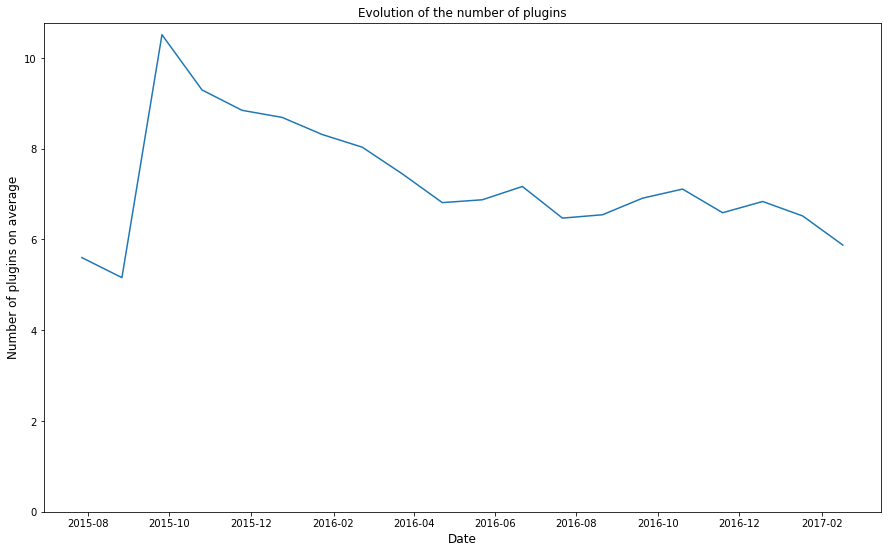

In [24]:
plugins_changes=[]

for user_id in df_user_more_2_fingerprints['index']:
    
    # sort the dataframe by date of creation
    df_filtered_id = df_consistent[df_consistent['id']==user_id].sort_values('creationDate')

    for line in range(0,len(df_filtered_id)):
        plugins_changes.append({
            "date":df_filtered_id.iloc[line]['creationDate'],
            "plug": len(str(df_filtered_id["pluginsJS"].iloc[line]).split(":"))-1
        })            

# sort of dataframe by date
df_plugins_changes = pd.DataFrame(plugins_changes)
sorting_df_plugins_changes=df_plugins_changes.sort_values("date")

# enlarge the chart
fig = plt.figure(figsize=(15,9))

graph_plugins_changes = fig.add_subplot(1, 1, 1)

# groups the number of plugins by date and makes an average
average_plugins_by_xday=sorting_df_plugins_changes.set_index('date').groupby(pd.TimeGrouper('30D')).mean()

graph_plugins_changes.plot(average_plugins_by_xday)

# interval of the y-axis 
graph_plugins_changes.set_ylim(ymin=0)

graph_plugins_changes.set_title("Evolution of the number of plugins")
graph_plugins_changes.set_xlabel("Date", size = 12)
graph_plugins_changes.set_ylabel("Number of plugins on average", size = 12)


### Evolution of number of language in time

In [110]:
print("possible attributes are pluginsJS with the separator ':' and languageHttp with ','" )
def reason_change_attribut(attribute,split_separator):    
    evolution=[]
    for user_id in df_user_more_2_fingerprints['index']:
        sorted_date = df_consistent[df_consistent['id']==user_id].sort_values('creationDate')

        number=[]
        liste_languages = []
        
        # add to first value in the list
        liste_languages.append(sorted_date[attribute].iloc[0])

        # for each line of group of fingerprints of the user
        for line in range(1, len(sorted_date[attribute])):

            first_line = sorted_date[attribute].iloc[line-1]
            line_entire=sorted_date[attribute].iloc[line]

            # if line next is different to previous line then storage of line next
            if line_entire != first_line:
                liste_languages.append(line_entire)
                first_line = line_entire
            # else the first line becomes the next
            else:
                first_line = line_entire

        df_languages = pd.DataFrame(liste_languages)

        for key, line in df_languages.iterrows():
            number.append({
                "cle": key,
                attribute:len(str(line).split(split_separator))-1
            })


        df_number = pd.DataFrame(number)

        # take only values of users with a changement so with more 2 numbers so 2 values in df_number
        if len(df_number)>=2:
            
            # first value
            nb_debut=df_number[attribute].iloc[0]
            
            # last value
            nb_fin=df_number[attribute].iloc[-1]
            
            # evoluton of number of plugins or languages for each user
            nb_final=nb_fin-nb_debut

            # add to this evolution in the list named evolution
            evolution.append(nb_final)

            
    count_inf=0
    count_sup=0
    count_zero=0
    for i in range(0,len(evolution)):
        
        # if the evolution of number of plugins or languages <0 then there is a decrease
        if evolution[i]<0:
            count_inf=count_inf+1
            
        # if the evolution of number of plugins or languages >0 then there is an increase
        elif evolution[i]>0:
            count_sup=count_sup+1
            
        # if there is neither then there is no evolution
        else:
            count_zero=count_zero+1

    print("The number of {} decreases for {:d} id".format(attribute, count_inf))
    print("The number of {} increases for {:d} id".format(attribute, count_sup))
    print("The number of {} stagnates for {:d} id".format(attribute, count_zero))
    


possible attributes are pluginsJS with the separator ':' and languageHttp with ','


In [109]:
reason_change_attribut("languageHttp", ",")

The number of languageHttp decreases for 93 id
The number of languageHttp increases for 78 id
The number of languageHttp stagnates for 91 id


/home/spirals/PycharmProjects/stage/myvenv/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)


Text(0,0.5,'Number of languages on average')

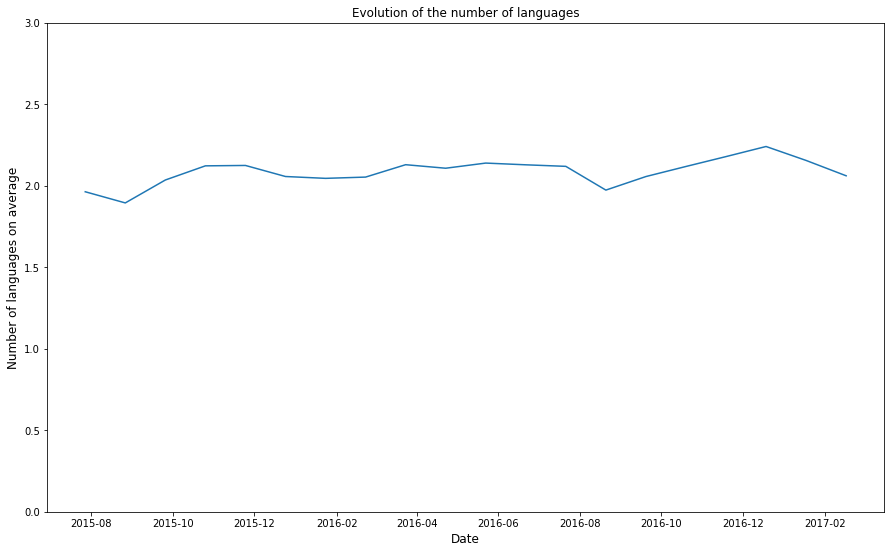

In [81]:
nb_languages=[]
for user_id in df_user_more_2_fingerprints['index']:
    
    # sort the dataframe by date of creation
    df_filtered_id = df_consistent[df_consistent['id']==user_id].sort_values('creationDate')
    for value in range(0,len(df_filtered_id['languageHttp'])):
        nb_languages.append({
            "date":df_filtered_id.iloc[value]['creationDate'],
            "number_languages": len((df_filtered_id['languageHttp'].iloc[value].split(",")))-1
        })
        
# sort of dataframe by date
df_nb_languages = pd.DataFrame(nb_languages)
sorting_df_nb_languages=df_nb_languages.sort_values("date")
            
# enlarge the chart
fig = plt.figure(figsize=(15,9))

graph_nb_languages = fig.add_subplot(1, 1, 1)

# groups the number of languages by date and makes an average
average_languages_by_xday=sorting_df_nb_languages.set_index('date').groupby(pd.TimeGrouper('30D')).mean()

graph_nb_languages.plot(average_languages_by_xday)

# interval of the y-axis 
graph_nb_languages.set_ylim(0,3)

graph_nb_languages.set_title("Evolution of the number of languages")
graph_nb_languages.set_xlabel("Date", size = 12)
graph_nb_languages.set_ylabel("Number of languages on average", size = 12)

### Evolution of priority of languages over time

/home/spirals/PycharmProjects/stage/myvenv/lib/python3.6/site-packages/ipykernel_launcher.py:33: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)


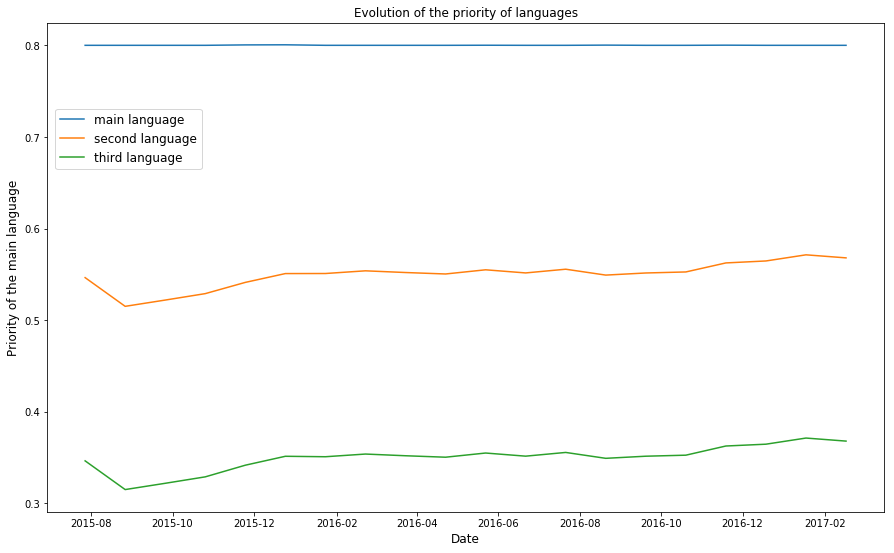

In [151]:
priority_languages=[]
for user_id in df_user_more_2_fingerprints['index']:
    
    # sort the dataframe by date of creation
    df_filtered_id = df_consistent[df_consistent['id']==user_id].sort_values('creationDate')
    for value in range(0,len(df_filtered_id['languageHttp'])):
        list_languages = df_filtered_id['languageHttp'].iloc[value].split(",")
        df_list_languages = pd.DataFrame(list_languages)
        
        # for splitter when there is no "="
        try:
            # 1 to take the first priority, 2 for the second and 3 for the third
            select_number_first_priority = df_list_languages[0].str.split("=")[1]
            select_number_second_priority = df_list_languages[0].str.split("=")[2]
            select_number_third_priority = df_list_languages[0].str.split("=")[3]
            priority_languages.append({
                "date":df_filtered_id.iloc[value]['creationDate'],
                "main language": float(select_number_first_priority[1]),
                "second language": float(select_number_second_priority[1]),
                "third language": float(select_number_third_priority[1])
            })
        except:
            # otherwise it goes to the next line
            value = value+1

        
# sort of dataframe by date for the plot
df_priority_languages = pd.DataFrame(priority_languages)
sorting_df_priority_languages=df_priority_languages.sort_values("date")
            
# enlarge the chart
fig = plt.figure(figsize=(15,9))

graph_priority_languages = fig.add_subplot(1, 1, 1)

# groups the priority by date and makes an average
average_priority_by_xday=sorting_df_priority_languages.set_index('date').groupby(pd.TimeGrouper('30D')).mean()

# drawing of the 3 curves and for the legend
graph_priority_languages.plot(average_priority_by_xday["main language"])
graph_priority_languages.plot(average_priority_by_xday["second language"])
graph_priority_languages.plot(average_priority_by_xday["third language"])

graph_priority_languages.set_title("Evolution of the priority of languages")
graph_priority_languages.set_xlabel("Date", size = 12)
graph_priority_languages.set_ylabel("Priority of the main language", size = 12)

# position of legend
graph_priority_languages.legend(loc=[0.01,0.7], prop={'size': 12})


### At a given moment, for the same browser, do the majority of people have the same version?

In [68]:
print("Browsers are : {}".format(df_consistent["browserFamily"].unique()))
print("Choose a date betwwen {} and {}".format(min(df_consistent['creationDate']),max(df_consistent['creationDate'])))
def analyze_version_same_browser(browser, year_min, month_min, day_min , year_max, month_max, day_max):   
    select_browser=[]
    for i in range(0, len(df_consistent["browserFamily"])):
        if df_consistent["browserFamily"].iloc[i]==browser:
            select_browser.append({
                "user":df_consistent["id"].iloc[i],
                "date":df_consistent["creationDate"].iloc[i],
                "version":df_consistent["majorBrowserVersion"].iloc[i]
            })
    df_select_browser = pd.DataFrame(select_browser)
    select_date=[]
    for i in range(0,len(df_select_browser)):
        if df_select_browser["date"].iloc[i].date() <= date(year_max,month_max,day_max) and df_select_browser["date"].iloc[i].date() >= date(year_min,month_min,day_min): 
            select_date.append({
                "user":df_select_browser["user"].iloc[i],
                "date":df_select_browser["date"].iloc[i],
                "version":df_select_browser["version"].iloc[i]
            })
    df_select_date = pd.DataFrame(select_date)        

    # delete lines where user appears twice and keep the first appearance
    select_users = df_select_date.drop_duplicates(subset="user", keep='first', inplace=False)

    select_users_version = select_users.groupby(["version"]).size()
    
# graph

    graph_browser_version = select_users_version.plot.bar(figsize=(18, 9))
    N=len(select_users_version)

    # put bar effective in a list
    bar_values = []
    for i in graph_browser_version.patches:
        bar_values.append(i.get_height())

    # sum of effective
    sum_all = sum(bar_values)

    # set the percentage at each bar
    for i in graph_browser_version.patches:
        # get_x to put in left or right; get_height to put in up or down
        # calculation of the percentage rounded to the hundredth : effective/n*100
        graph_browser_version.text(i.get_x()+0.15, i.get_height()+0.8, \
                str(round((i.get_height()/sum_all)*100, 2))+'%', fontsize=11,
                    color='black')


    graph_browser_version.set_title("Barplot of distinct versions for the browser '{}' between {}-{}-{} and {}-{}-{}".format(browser,year_min,month_min,day_min,year_max,month_max,day_max),size = 14)
    graph_browser_version.set_xlabel("version of browser {}".format(browser), size = 12)
    graph_browser_version.set_ylabel("Number of users", size = 12)
    plt.xticks(size=12,rotation = 0)
#     graph_browser_version.autofmt_xdate()
    plt.xticks(size=12)

Browsers are : ['Chrome' 'Chromium' 'Firefox' 'Iceweasel' 'Vivaldi' 'Iron' 'Other'
 'Maxthon' 'Yandex Browser' 'Dragon' 'Opera' 'Pale Moon (Firefox Variant)'
 'SeaMonkey' 'Rekonq' 'Epiphany' 'QupZilla' 'IE Mobile' 'Konqueror']
Choose a date betwwen 2015-07-27 11:00:00 and 2017-03-13 01:00:00


In [125]:
print("Browsers are : {}".format(df_consistent["browserFamily"].unique()))
print("Choose a date betwwen {} and {}".format(min(df_consistent['creationDate']),max(df_consistent['creationDate'])))
def analyze_version_same_browser(browser, year_min, month_min, day_min , year_max, month_max, day_max):   
    select_browse=[]
    for i in range(0, len(df_consistent["browserFamily"])):
        if df_consistent["browserFamily"].iloc[i]==browser:
            select_browse.append({
                "user":df_consistent["id"].iloc[i],
                "date":df_consistent["creationDate"].iloc[i],
                "version":df_consistent["majorBrowserVersion"].iloc[i]
            })
    df_select_browse = pd.DataFrame(select_browse)
    print(df_select_browse["date"])
    select_date=[]
    for i in range(0,len(df_select_browse)):
        if df_select_browse["date"].iloc[i].date() <= date(year_max,month_max,day_max) and df_select_browse["date"].iloc[i].date() >= date(year_min,month_min,day_min): 
            select_date.append({
                "user":df_select_browse["user"].iloc[i],
                "date":df_select_browse["date"].iloc[i],
                "version":df_select_browse["version"].iloc[i]
            })
#     df_select_date = pd.DataFrame(select_date)        

#     # delete lines where user appears twice and keep the first appearance
#     select_users = df_select_date.drop_duplicates(subset="user", keep='first', inplace=False)

#     select_users_version = select_users.groupby(["version"]).size()
#     print(select_users_version)

    
# graph

#     graph_browser_version = select_users_version.plot.bar(figsize=(18, 9))
#     N=len(select_users_version)

#     # put bar effective in a list
#     bar_values = []
#     for i in graph_browser_version.patches:
#         bar_values.append(i.get_height())

#     # sum of effective
#     sum_all = sum(bar_values)

#     # set the percentage at each bar
#     for i in graph_browser_version.patches:
#         # get_x to put in left or right; get_height to put in up or down
#         # calculation of the percentage rounded to the hundredth : effective/n*100
#         graph_browser_version.text(i.get_x()-0.2, i.get_height()+1.8, \
#                 str(round((i.get_height()/sum_all)*100, 2))+'%', fontsize=11,
#                     color='dimgrey')


#     graph_browser_version.set_title("Barplot of distinct versions for the browser '{}' between {}-{}-{} and {}-{}-{}".format(browser,year_min,month_min,day_min,year_max,month_max,day_max))
#     graph_browser_version.set_xlabel("version of browser {}".format(browser), size = 12)
#     graph_browser_version.set_ylabel("Number of users", size = 12)
#     plt.xticks(size=12,rotation = 40)
#     plt.xticks(size=12)

Browsers are : ['Chrome' 'Chromium' 'Firefox' 'Iceweasel' 'Vivaldi' 'Iron' 'Other'
 'Maxthon' 'Yandex Browser' 'Dragon' 'Opera' 'Pale Moon (Firefox Variant)'
 'SeaMonkey' 'Rekonq' 'Epiphany' 'QupZilla' 'IE Mobile' 'Konqueror']
Choose a date betwwen 2015-07-27 11:00:00 and 2017-03-13 01:00:00


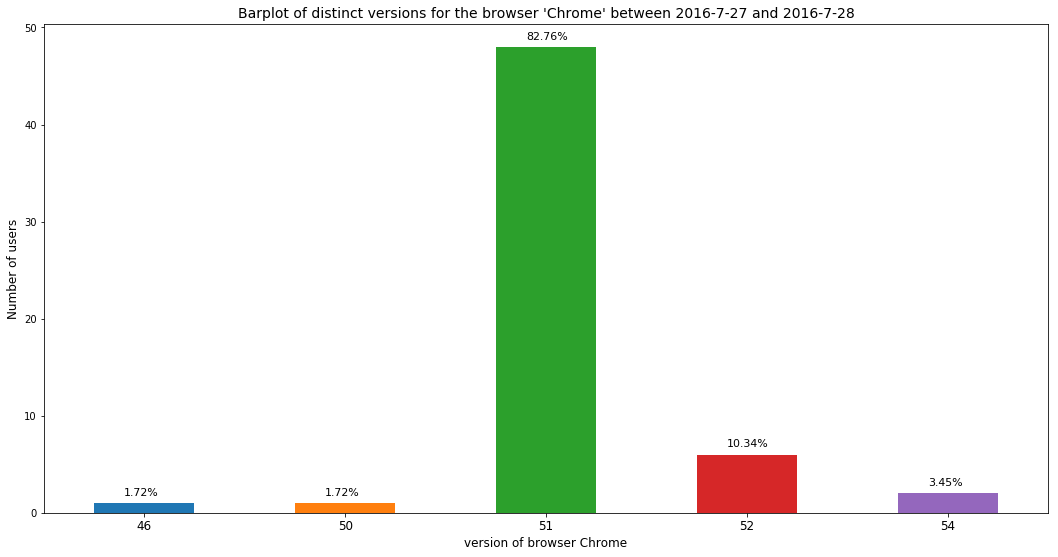

In [69]:
analyze_version_same_browser("Chrome", 2016, 7, 27, 2016, 7, 28)

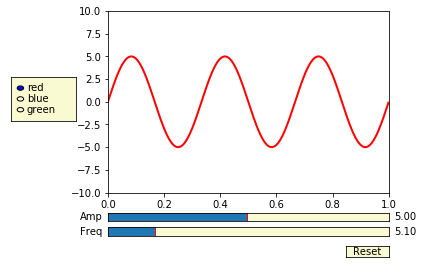

In [47]:
from matplotlib.widgets import Slider, Button, RadioButtons

fig, ax = plt.subplots()
plt.subplots_adjust(left=0.25, bottom=0.25)
t = np.arange(0.0, 1.0, 0.001)
a0 = 5
f0 = 3
delta_f = 5.0
s = a0*np.sin(2*np.pi*f0*t)
l, = plt.plot(t, s, lw=2, color='red')
plt.axis([0, 1, -10, 10])

axcolor = 'lightgoldenrodyellow'
axfreq = plt.axes([0.25, 0.1, 0.65, 0.03], facecolor=axcolor)
axamp = plt.axes([0.25, 0.15, 0.65, 0.03], facecolor=axcolor)

sfreq = Slider(axfreq, 'Freq', 0.1, 30.0, valinit=f0, valstep=delta_f)
samp = Slider(axamp, 'Amp', 0.1, 10.0, valinit=a0)


def update(val):
    amp = samp.val
    freq = sfreq.val
    l.set_ydata(amp*np.sin(2*np.pi*freq*t))
    fig.canvas.draw_idle()
sfreq.on_changed(update)
samp.on_changed(update)

resetax = plt.axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', color=axcolor, hovercolor='0.975')


def reset(event):
    sfreq.reset()
    samp.reset()
button.on_clicked(reset)

rax = plt.axes([0.025, 0.5, 0.15, 0.15], facecolor=axcolor)
radio = RadioButtons(rax, ('red', 'blue', 'green'), active=0)


def colorfunc(label):
    l.set_color(label)
    fig.canvas.draw_idle()
radio.on_clicked(colorfunc)

plt.show()